## Problem Set 2 (problem 4)
#### Description: Diagnosing Weak Instrument Problem
#### Authors: Bobing, Cassandra, Max, Prema, Rajdev, and Yazen
#### Date last modified: April 14, 2023

# ---------
Set-up:

$$y = x\beta + e$$

$$x = Z\pi + u$$ where 

For this problem, we use the following dimensions:

1. $y$ is $N\times 1$ 
2. $x$ is $N\times 1$ 
3. $Z$ is $N\times l$
4. beta is $1\times1$
5. pi is $l\times1$

# ---------

## Part 1 

In [182]:
import numpy as np
import scipy.stats.distributions as iid
import scipy.stats
import matplotlib.pyplot as plt
from numpy.linalg import inv
import math
import random

In [183]:
# DGP: y, x
def dgp(N, beta, pi):
    '''
    Data-generating process
    
    Inputs
    ------
    N (int) number of obervations
    beta (float) true parameter
    pi (lx1 np.array) tur first stage parameter
    
    Returns
    -------
    y (Nx1 np.array)
    x (Nx1 np.array)
    Z (Nxl np.array)
    '''
    # infer number of instruments from the size of pi
    l = pi.shape[0]
    # first generate Z
    Z = scipy.stats.multivariate_normal(np.zeros(l), np.eye(l)).rvs(size=N)
    if len(Z.shape) == 1:
        Z = Z.reshape(-1,1)
    
    # now build X
    X = Z@pi + iid.norm().rvs(size=(N,1))

    # finally, build y ; note that beta is unbiased here as the error term is randomly generated, and not correlated to x
    y = X*beta + iid.norm().rvs(size=(N,1))
    
    return y, X, Z

In [184]:
# test
N = 10
beta = 1
pi = np.array([[1], [1]])
dgp(N, beta, pi)

(array([[-2.38037747],
        [-0.30568641],
        [-1.37315097],
        [-3.62292988],
        [-0.88942196],
        [ 3.95672347],
        [ 1.18447627],
        [-3.924025  ],
        [-2.5851072 ],
        [-0.11022104]]),
 array([[ 0.29869732],
        [-0.91872558],
        [-1.08938031],
        [-2.48373235],
        [ 0.08844825],
        [ 3.32357599],
        [ 0.55475063],
        [-0.99384649],
        [-1.75852804],
        [-1.53999232]]),
 array([[ 0.67183969, -0.09759989],
        [ 0.66803776,  0.1436952 ],
        [ 0.182625  , -0.04603056],
        [-0.93040285, -0.90850058],
        [ 0.07051975, -1.48853175],
        [ 1.60470222,  1.79589641],
        [ 1.72117981, -0.28334608],
        [-0.87757689,  0.14219995],
        [-1.2861541 , -0.85641862],
        [-0.20594516, -0.13357382]]))

## Part 2

## 2 (a) 
Note:
1. l = 1 (i.e., we only have 1 instrument in this case)
2. Errors are homoskedastic

In [185]:
# trial
def two_sls(y, X, Z):
    '''
    Estimate 2 stage least squares given data on y, X and Z.
    
    Inputs:
    -------
    y (Nx1 np.array)
    X (Nx1 np.array)
    Z (Nxl np.array)
    
    Returns
    -------
    beta_hat, vb_beta_hat
    '''
    y = np.array(y)
    X = np.array(X)
    Z = np.array(Z)
    ZX = np.transpose(Z)@X
    ZX_inv = np.linalg.pinv(ZX)#using pseuodo-inverse
    Zy = np.transpose(Z)@y
    ZZ = np.transpose(Z)@Z
    ZZ_inv = np.linalg.pinv(ZZ)
    #Beta_IV2SLS = ZX_inv@ZY
    beta_hat = np.linalg.pinv(np.transpose(ZX)@ZZ_inv@ZX)@(np.transpose(ZX)@ZZ_inv@Zy)
    e = y - X@beta_hat
    SSR = np.transpose(e)@e
    N = X.shape[0]
    vcv = (SSR/N)*np.linalg.pinv(np.transpose(ZX)@ZZ_inv@ZX)
    K = X.shape[1]
    se_beta_hat = np.zeros(K)
    for i in range(K):
          se_beta_hat[i] = np.sqrt(vcv[i,i])
            
    return beta_hat, se_beta_hat

    

In [186]:
random.seed(11)

In [187]:
# test 
y, X, Z = dgp(1000, 1, np.array([[1],[0.5],[0.25],[0.125]]))
print(two_sls(y, X, Z))

(array([[0.99367225]]), array([0.02795285]))


#### Wrapping up: Monte-Carlo Function

In [188]:
# wrapping everything up in one function
def monteCarlo(N, beta, pi):
    y, X, Z = dgp(N, beta, pi)
    return two_sls(y, X, Z)

In [189]:
# test
monteCarlo(1000,1,np.array([[1],[1]]))

(array([[1.02857668]]), array([0.02107417]))

## 2 (b) 

Note: $\beta=\pi=1$
We compare 3 dataset sizes: N=100, N=1000, and N=10000 to check the following:
1. Bias of beta_hat
2. Precision of beta_hat
3. Size of t-test (beta = 0)
4. Power of t-test (beta = 0)


### Estimated beta 

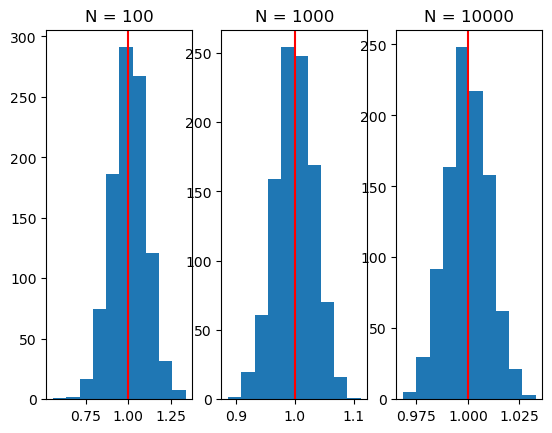

In [190]:
counter = 0 # first axis starts at 0
fig, ax = plt.subplots(1, 3) # initialize 3 subplots

# set global parameters for DGP
beta = 1
pi = np.array([[1]])
for N in [100, 1000, 10000]:
    # calculate IV a bunch of times
    beta_hats = [monteCarlo(N, beta, pi)[0].item() for i in range(1000)]
    # plot
    ax[counter].hist(beta_hats)
    ax[counter].set_title(f"N = {N}")
    ax[counter].axvline(x=1, color='r', label='True beta')

    # advance counter
    counter = counter + 1

### Estimated standard error of beta

In [ ]:
counter = 0 # first axis starts at 0
fig, ax = plt.subplots(1, 3) # initialize 3 subplots

# set global parameters for DGP
beta = 1
pi = np.array([[1]])
for N in [100, 1000, 10000]:
    # calculate IV a bunch of times
    se_beta_hat = [monteCarlo(N, beta, pi)[1].item() for i in range(1000)]
    # plot
    ax[counter].hist(se_beta_hat)
    ax[counter].set_title(f"N = {N}")
    # advance counter
    counter = counter + 1

#### Testing the t-statistic

In [191]:
# N = 100
from statsmodels.regression.linear_model import OLS
y, X, Z = dgp(1000, 1, np.array([[1]]))
xhat = X@np.linalg.solve(Z.T@Z, Z.T@X)
print()
OLS(y,xhat).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.686
Model:                            OLS   Adj. R-squared (uncentered):              0.686
Method:                 Least Squares   F-statistic:                              2184.
Date:                Fri, 14 Apr 2023   Prob (F-statistic):                   1.32e-253
Time:                        19:06:38   Log-Likelihood:                         -1370.0
No. Observations:                1000   AIC:                                      2742.
Df Residuals:                     999   BIC:                                      2747.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9722      0.021     46.730      0.000       0.931       1.013
==============================================================================
Omnibus:                        5.189   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                5.286
Skew:                          -0.130   Prob(JB):                       0.0711
Kurtosis:                       3.244   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# N = 1000
from statsmodels.regression.linear_model import OLS
y, X, Z = dgp(10000, 1, np.array([[1]]))
xhat = X@np.linalg.solve(Z.T@Z, Z.T@X)
print()
OLS(y,xhat).fit().summary()

In [ ]:
# N = 10000
from statsmodels.regression.linear_model import OLS
y, X, Z = dgp(10000, 1, np.array([[1]]))
xhat = X@np.linalg.solve(Z.T@Z, Z.T@X)
print()
OLS(y,xhat).fit().summary()

### Takeaway
<br>
Yes, a 95% confidence interval estimated by the 2SLS estimator above almost correctly covers 95% of our Monte Carlo draws for the three values of N we considered.
<br>
For example, when N = 1000: 
<br>
95% CI estimated by 2SLS estimator = [0.956,1.041]
<br>
95% of Monte Carlo draws = [0.90, 1.10]

#### <font color='red'>t-test (size and power) -- need to doublecheck!</font> 

In [8]:
# import statsmodels.stats.power as smp
# smp.ttest_power(0.8, nobs=1000, alpha=0.05, alternative='two-sided')

##### References:
1. https://stackoverflow.com/questions/54067722/calculate-power-for-t-test-in-python (power, effect size)
2. https://machinelearningmastery.com/effect-size-measures-in-python/ (effect size)
3. https://en.wikipedia.org/wiki/Effect_size (wiki definitions)
4. https://rowannicholls.github.io/python/statistics/effect_size.html 

## 2 (c)
Now let's iterate over $\pi$ instead of N, seeing how we do with varyingly weak instruments.
<br>
Note: We use sample size N = 1000 

### Estimated beta

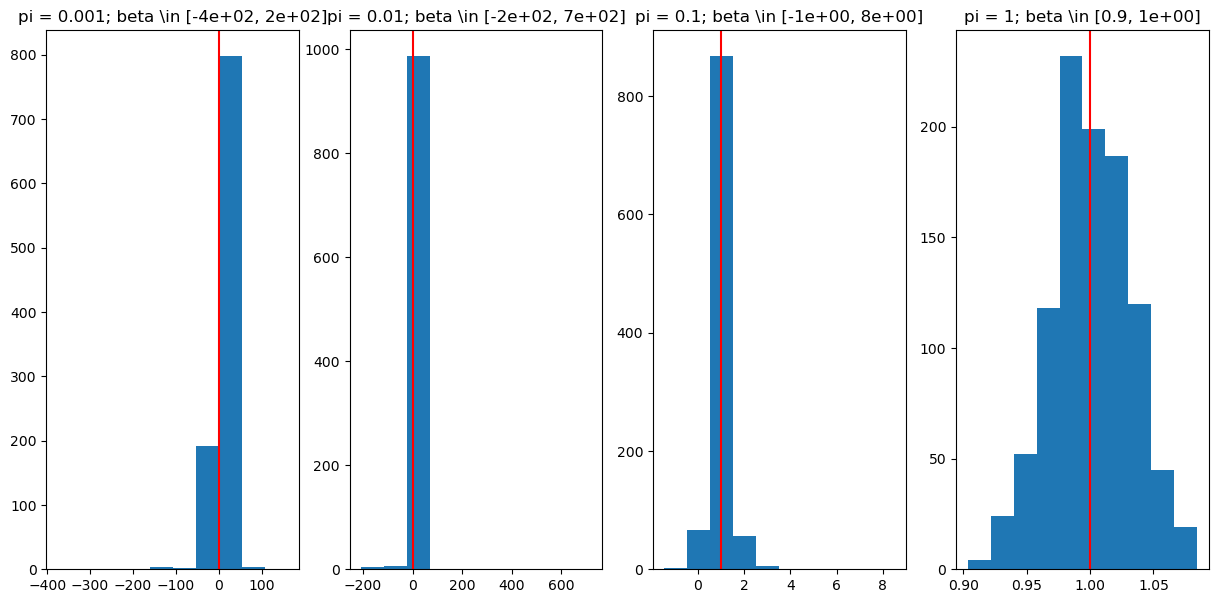

In [192]:
counter = 0 # first axis starts at 0
fig, ax = plt.subplots(1, 4, figsize=(15,7)) # initialize 3 subplots

# set global parameters for DGP
beta = 1
N = 1000

# start empty list to save to
beta_hats = []

for p in [0.001, 0.01, 0.1, 1]:
    # calculate IV a bunch of times
    beta_hats = np.array([monteCarlo(N, beta, np.array([[p]]))[0].item() for i in range(1000)])
    # some stats
    minbeta = beta_hats.min()
    maxbeta = beta_hats.max()
    # plot
    ax[counter].hist(beta_hats)
    ax[counter].set_title(f"pi = {p}; beta \in [{minbeta:.1}, {maxbeta:.1}]")
    ax[counter].axvline(x=1, color='r', label='True beta')

    # advance counter
    counter = counter + 1

### Estimated standard error of beta

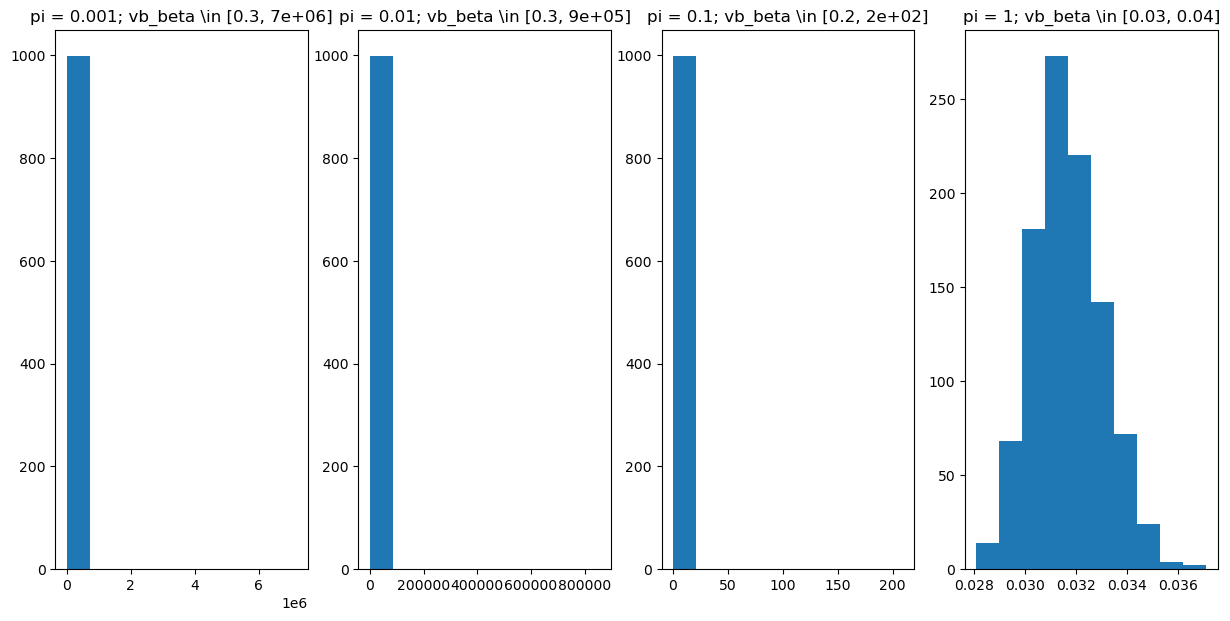

In [193]:
counter = 0 # first axis starts at 0
fig, ax = plt.subplots(1, 4, figsize=(15,7)) # initialize 3 subplots

# set global parameters for DGP
beta = 1
N = 1000

# start empty list to save to
se_beta_hat = []

for p in [0.001, 0.01, 0.1, 1]:
    # calculate IV a bunch of times
    se_beta_hat = np.array([monteCarlo(N, beta, np.array([[p]]))[1].item() for i in range(1000)])
    # some stats
    minvb = se_beta_hat.min()
    maxvb = se_beta_hat.max()
    # plot
    ax[counter].hist(se_beta_hat)
    ax[counter].set_title(f"pi = {p}; se_beta \in [{minvb:.1}, {maxvb:.1}]")

    # advance counter
    counter = counter + 1

#### Testing the t-statistic

In [23]:
# p = 0.001
from statsmodels.regression.linear_model import OLS
y, X, Z = dgp(1000, 1, np.array([[0.001]]))
xhat = X@np.linalg.solve(Z.T@Z, Z.T@X)
print()
OLS(y,xhat).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.468
Model:                            OLS   Adj. R-squared (uncentered):              0.467
Method:                 Least Squares   F-statistic:                              878.2
Date:                Fri, 14 Apr 2023   Prob (F-statistic):                   5.39e-139
Time:                        17:03:56   Log-Likelihood:                         -1441.0
No. Observations:                1000   AIC:                                      2884.
Df Residuals:                     999   BIC:                                      2889.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            14.0475      0.474     29.634      0.000      13.117      14.978
==============================================================================
Omnibus:                        2.366   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.306   Jarque-Bera (JB):                2.172
Skew:                          -0.039   Prob(JB):                        0.338
Kurtosis:                       2.785   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
# p = 0.01
from statsmodels.regression.linear_model import OLS
y, X, Z = dgp(1000, 1, np.array([[0.01]]))
xhat = X@np.linalg.solve(Z.T@Z, Z.T@X)
print()
OLS(y,xhat).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.462
Model:                            OLS   Adj. R-squared (uncentered):              0.462
Method:                 Least Squares   F-statistic:                              858.4
Date:                Fri, 14 Apr 2023   Prob (F-statistic):                   1.08e-136
Time:                        17:02:49   Log-Likelihood:                         -1448.8
No. Observations:                1000   AIC:                                      2900.
Df Residuals:                     999   BIC:                                      2905.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            38.0657      1.299     29.298      0.000      35.516      40.615
==============================================================================
Omnibus:                        1.424   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.491   Jarque-Bera (JB):                1.295
Skew:                           0.054   Prob(JB):                        0.523
Kurtosis:                       3.139   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
# p = 0.1
from statsmodels.regression.linear_model import OLS
y, X, Z = dgp(1000, 1, np.array([[0.1]]))
xhat = X@np.linalg.solve(Z.T@Z, Z.T@X)
print()
OLS(y,xhat).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.471
Model:                            OLS   Adj. R-squared (uncentered):              0.471
Method:                 Least Squares   F-statistic:                              890.7
Date:                Fri, 14 Apr 2023   Prob (F-statistic):                   1.94e-140
Time:                        17:01:24   Log-Likelihood:                         -1407.8
No. Observations:                1000   AIC:                                      2818.
Df Residuals:                     999   BIC:                                      2822.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            12.7837      0.428     29.845      0.000      11.943      13.624
==============================================================================
Omnibus:                        0.395   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.821   Jarque-Bera (JB):                0.282
Skew:                          -0.009   Prob(JB):                        0.869
Kurtosis:                       3.080   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
# p = 1
from statsmodels.regression.linear_model import OLS
y, X, Z = dgp(1000, 1, np.array([[1]]))
xhat = X@np.linalg.solve(Z.T@Z, Z.T@X)
print()
OLS(y,xhat).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.652
Model:                            OLS   Adj. R-squared (uncentered):              0.651
Method:                 Least Squares   F-statistic:                              1870.
Date:                Fri, 14 Apr 2023   Prob (F-statistic):                   4.73e-231
Time:                        17:01:19   Log-Likelihood:                         -1457.8
No. Observations:                1000   AIC:                                      2918.
Df Residuals:                     999   BIC:                                      2922.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9854      0.023     43.238      0.000       0.941       1.030
==============================================================================
Omnibus:                        0.249   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.883   Jarque-Bera (JB):                0.188
Skew:                           0.030   Prob(JB):                        0.910
Kurtosis:                       3.032   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### <font color='red'>t-test (size and power) -- need to doublecheck!</font> 


### Takeaways
<br>
1. As pi -> 0 (i.e., the instrument 'Z' becomes weaker), our Monte Carlo simulations show that the estimates of beta become more biased and move away from the true value of beta. Additionally, the estimates become less precise, with the variance increasing as the instrument becomes weaker.  
<br>
2. This problem does *not* go away even if we consider the estimates of beta with an asymptotic sample size (note: I ran the above code for N=10000 and N=100000 to look at the asymptotic case).

#### <font color='red'>BUG: Need to see if the simulation below is running correctly </font> 

## Part 3

## 3 (a)

Note:
<br>
1. \beta = 1 
2. l = (1,2,3....) s.t. pi = (1,1/2,1/4....)
<br>
for l>1, this is an overidentified estimator

In [140]:
import math
a = 1
r = 1/2
length = 100

geometric = [a * r ** (n - 1) for n in range(1, length + 1)]


In [ ]:
### BUG: 

### Estimated beta

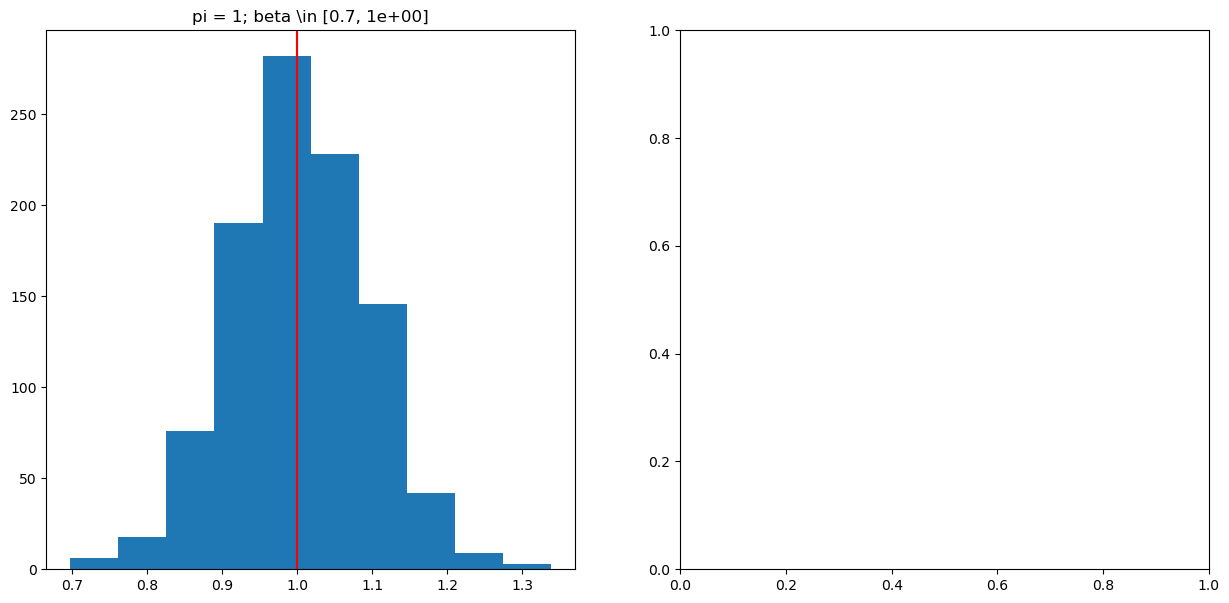

In [199]:
# Case 1 : p = [1] and l = 1
counter = 0 # first axis starts at 0
fig, ax = plt.subplots(1, 2, figsize=(15,7)) # initialize 3 subplots

# set global parameters for DGP
beta = 1
N = 100

# start empty list to save to
beta_hats = []
# calculate IV a bunch of times
beta_hats = np.array([monteCarlo(N, beta, np.array([[geometric[0]], [geometric[1]]]))[0].item() for i in range(1000)])
# some stats
minbeta = beta_hats.min()
maxbeta = beta_hats.max()
# plot
ax[counter].hist(beta_hats)
ax[counter].set_title(f"pi = {p}; beta \in [{minbeta:.1}, {maxbeta:.1}]")
ax[counter].axvline(x=1, color='r', label='True beta')

# advance counter
counter = counter + 1

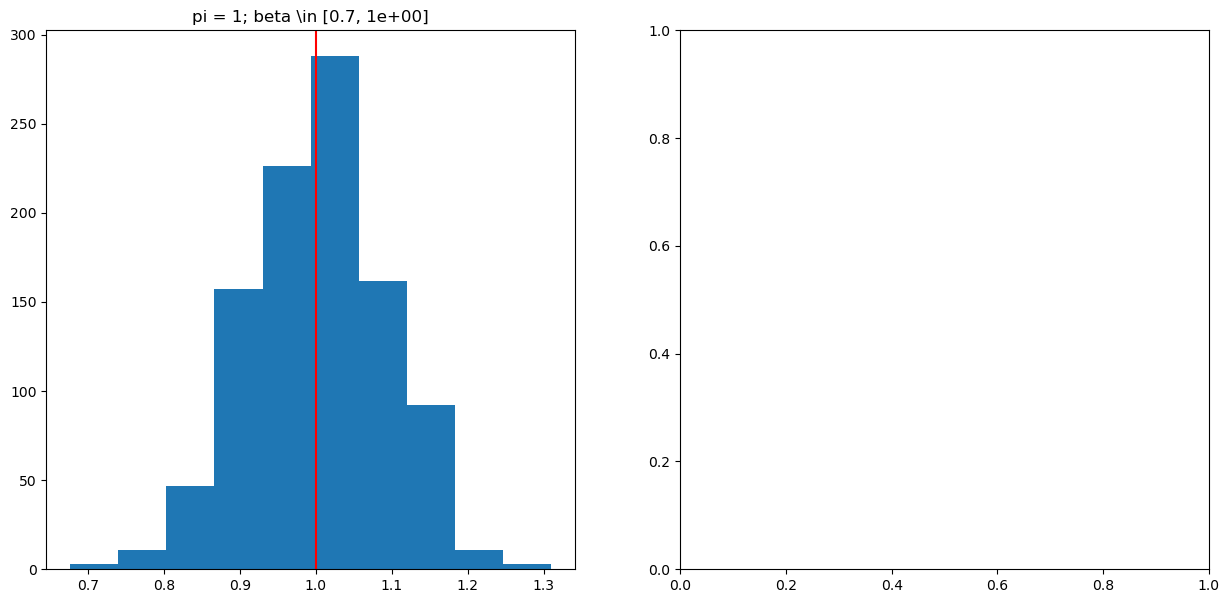

In [200]:
# Case 2 : p = [[1],[1/2],[1/4],[1/8],[1/16]] and l = 5

counter = 0 # first axis starts at 0
fig, ax = plt.subplots(1, 2, figsize=(15,7)) # initialize 3 subplots

# set global parameters for DGP
beta = 1
N = 100
a = 1
r = 1/2
n = 2

# start empty list to save to
beta_hats = []
# calculate IV a bunch of times
beta_hats = np.array([monteCarlo(N, beta, np.array([[geometric[0]],[geometric[1]],[geometric[2]],[geometric[3]],[geometric[4]]]))[0].item() for i in range(1000)])
# some stats
minbeta = beta_hats.min()
maxbeta = beta_hats.max()
# plot
ax[counter].hist(beta_hats)
ax[counter].set_title(f"pi = {p}; beta \in [{minbeta:.1}, {maxbeta:.1}]")
ax[counter].axvline(x=1, color='r', label='True beta')

# advance counter
counter = counter + 1

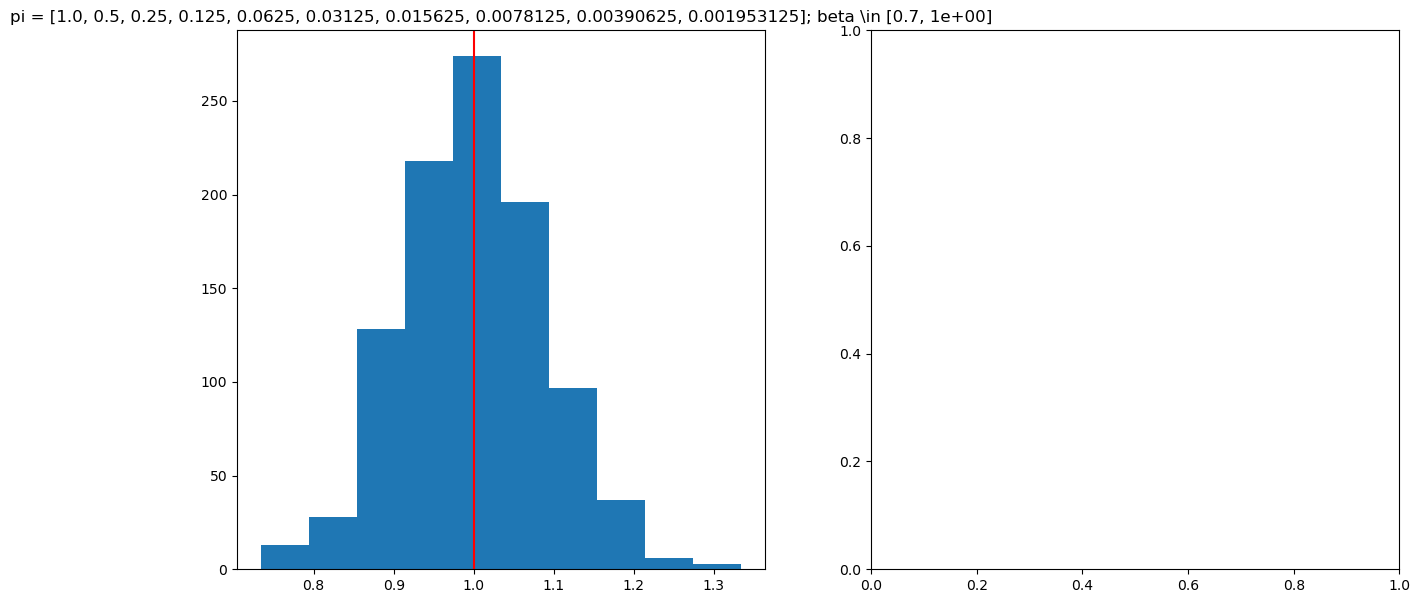

In [201]:
# Case 3 : p = [[1],[1/2],[1/4],[1/8],[1/16]......] and l = 10

counter = 0 # first axis starts at 0
fig, ax = plt.subplots(1, 2, figsize=(15,7)) # initialize 3 subplots

# set global parameters for DGP
beta = 1
N = 100
a = 1
r = 1/2
n = 2

# start empty list to save to
beta_hats = []
# calculate IV a bunch of times
beta_hats = np.array([monteCarlo(N, beta, np.array([[geometric[0]], [geometric[1]]]))[0].item() for i in range(1000)])
# some stats
minbeta = beta_hats.min()
maxbeta = beta_hats.max()
# plot
ax[counter].hist(beta_hats)
ax[counter].set_title(f"pi = {p}; beta \in [{minbeta:.1}, {maxbeta:.1}]")
ax[counter].axvline(x=1, color='r', label='True beta')

# advance counter
counter = counter + 1



### Estimated standard error of beta

#### <font color='red'> Need to run similar simulations as above for the standard error </font> 

## 3 (b)

#### <font color='red'>Need to comment on the optimal number of instruments </font> 

# rough work (not included in the solution)

In [ ]:
# test
counter = 0 # first axis starts at 0
fig, ax = plt.subplots(1, 2, figsize=(15,7)) # initialize 3 subplots

# set global parameters for DGP
beta = 1
N = 1000

# start empty list to save to
beta_hats = []

for p in [geometric[1]]:
    # calculate IV a bunch of times
    beta_hats = np.array([monteCarlo(N, beta, np.array([[p], [p]]))[0].item() for i in range(1000)])
    # some stats
    minbeta = beta_hats.min()
    maxbeta = beta_hats.max()
    # plot
    ax[counter].hist(beta_hats)
    ax[counter].set_title(f"pi = {p}; beta \in [{minbeta:.1}, {maxbeta:.1}]")
    ax[counter].axvline(x=1, color='r', label='True beta')

    # advance counter
    counter = counter + 1